# Scanpy tutorial
following along the [official one](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html).


1. data download

In [24]:
# !mkdir data
# !wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
# !cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
# !mkdir write

2. install libraries and scanpy setup

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc

In [3]:
sc.settings.verbosity = 3 # verbosity: errors(0), warnings(1), info(2), hints(3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white', color_map = 'viridis_r')

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.17.4 scipy==1.7.3 pandas==1.3.4 scikit-learn==1.0.1 statsmodels==0.13.1 pynndescent==0.5.5


In [4]:
# write a file that will store the analysis results
results_file = "write/pbmc3k.h5ad"

reading data into an [`AnnData`-object](https://anndata.readthedocs.io/en/latest/),
 useful for annotations and different representations of the data.  
 <img alt="anndata" height="5" src="figures/anndata_for_r.png" width="5"/>
 
mtx - file format: format for storing gene expression matrix

In [4]:
annotated_data = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',  # dir with matrix file `.mtx`
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                               # write a cache file for faster subsequent reading

annotated_data.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

... writing an h5ad cache file to speedup reading next time


normalizing counts per cell
    finished (0:00:00)


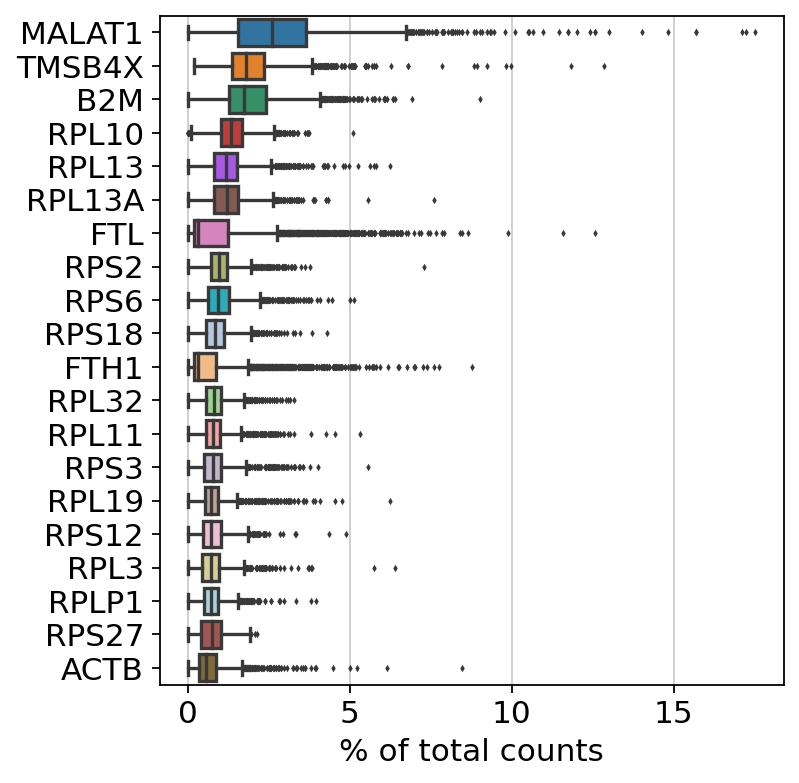

In [5]:
sc.pl.highest_expr_genes(annotated_data, n_top=20, )

In [6]:
# Basic filtering

sc.pp.filter_cells(annotated_data, min_genes=200)
sc.pp.filter_genes(annotated_data, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


Assembly of information about mitochondrial genes, which are important for QC

In [12]:
annotated_data.var['mt'] = annotated_data.var_names.str.startswith('MT-') # annotate the group of mitochondrial genes as "mt"
sc.pp.calculate_qc_metrics(annotated_data, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

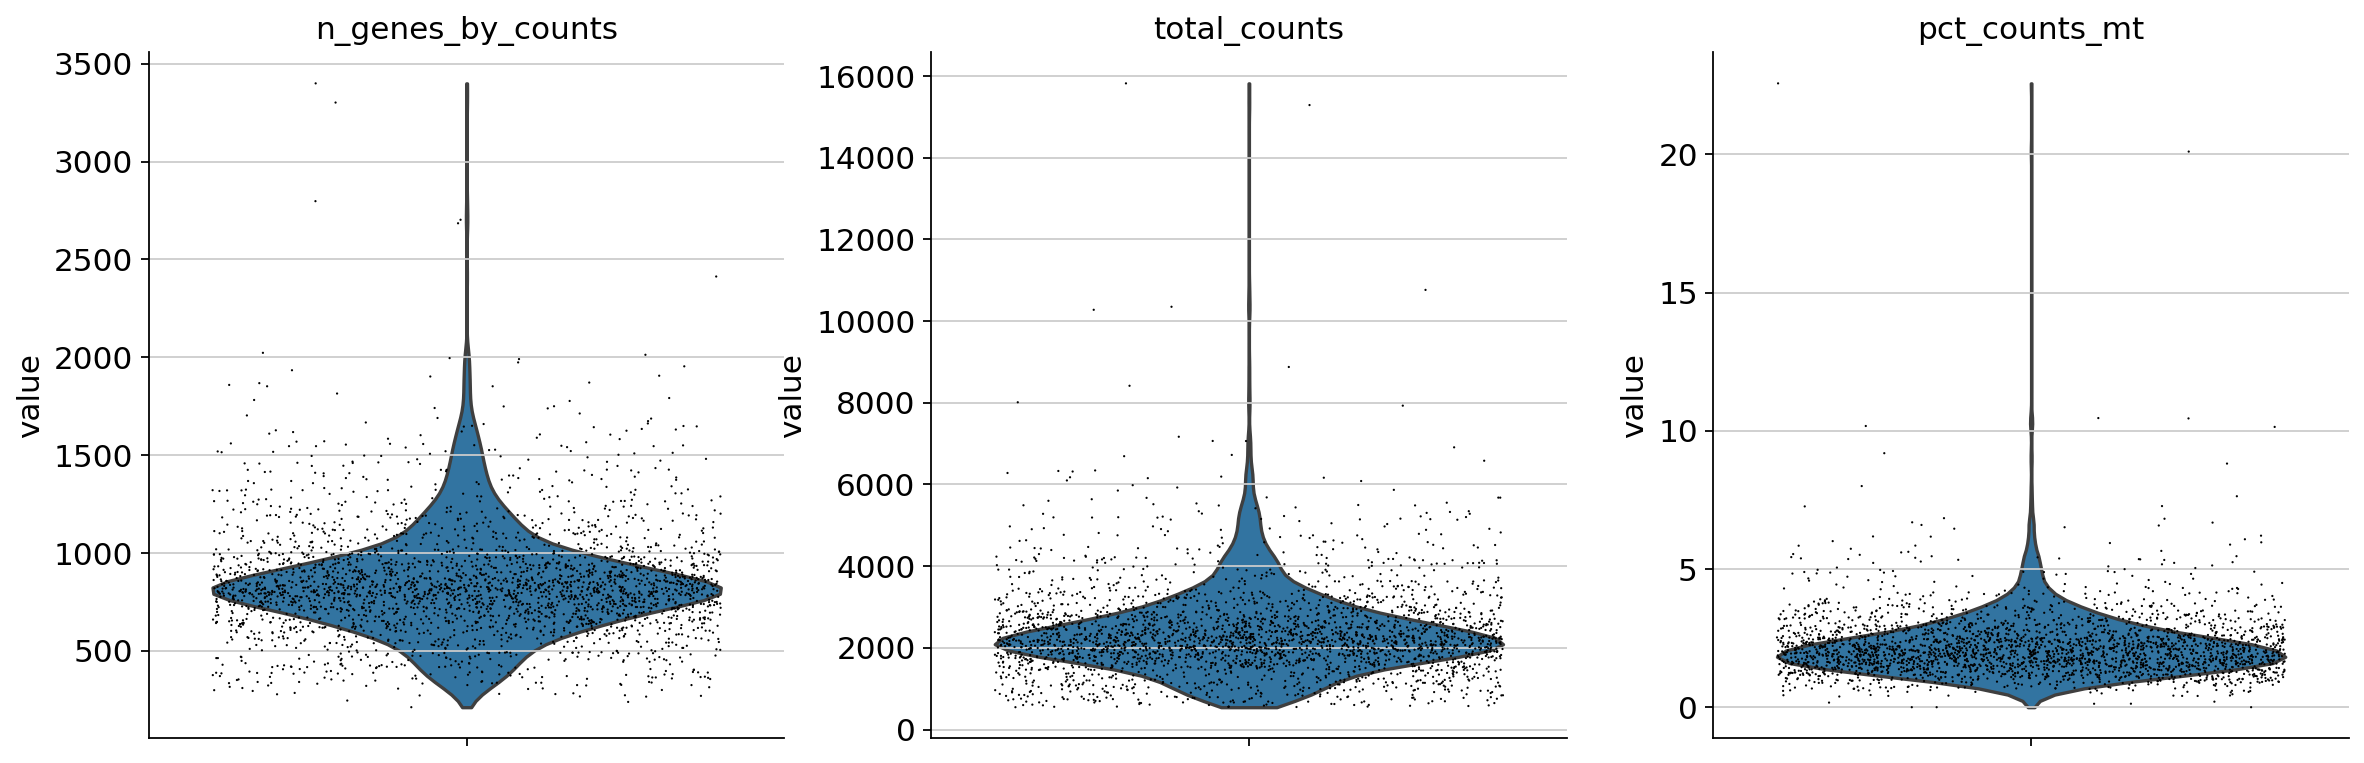

In [17]:
sc.pl.violin(annotated_data, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

## Filtering of cells with mitochondrial genes
### Scatter plot to see where to set the cutoff

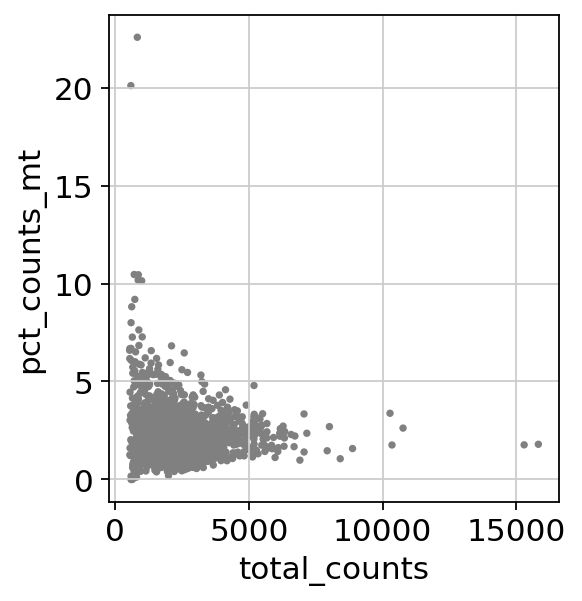

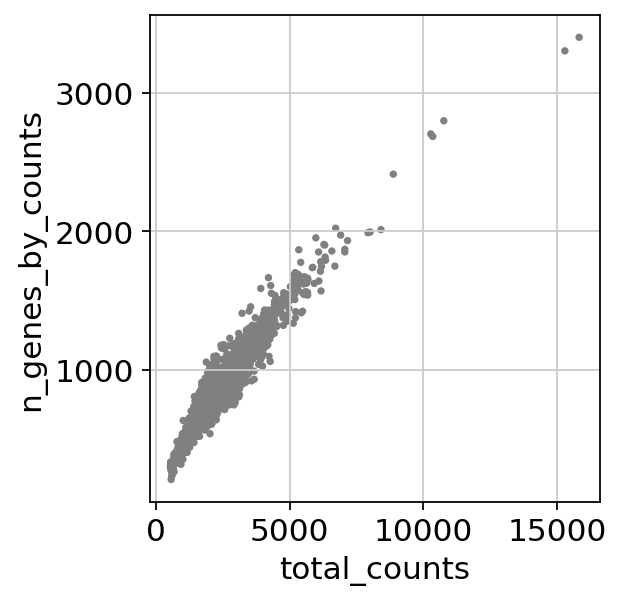

In [21]:
# get how many cells have high mitochondrial proportion
sc.pl.scatter(annotated_data, x='total_counts', y='pct_counts_mt')

# get how many cells have high gene counts too
sc.pl.scatter(annotated_data, x='total_counts', y='n_genes_by_counts')


### do the actual filtering
From the first plot we get that we get the most cells when cutting off at
5% mitochondrial genes.
Form the second plot we get that the cells with more than 2500 genes are probably outlier.
So we filter for those two values.

In [25]:
annotated_data_genecounts_filtered = annotated_data[annotated_data.obs.n_genes_by_counts < 2500, :]
annotated_data_genecount_mitochond_filtered = annotated_data_genecounts_filtered[annotated_data_genecounts_filtered.obs.pct_counts_mt < 5, :]

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
AAACATACAACCAC-1,781,779,2419.0,73.0,3.017776
AAACATTGAGCTAC-1,1352,1352,4903.0,186.0,3.793596
AAACATTGATCAGC-1,1131,1129,3147.0,28.0,0.889736
AAACCGTGCTTCCG-1,960,960,2639.0,46.0,1.743085
AAACCGTGTATGCG-1,522,521,980.0,12.0,1.224490
...,...,...,...,...,...
TTTCGAACTCTCAT-1,1155,1153,3459.0,73.0,2.110436
TTTCTACTGAGGCA-1,1227,1224,3443.0,32.0,0.929422
TTTCTACTTCCTCG-1,622,622,1684.0,37.0,2.197150
TTTGCATGAGAGGC-1,454,452,1022.0,21.0,2.054795
